## policy evaluation

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(mlr)))
suppressWarnings(suppressMessages(library(boot)))

In [2]:
dir_path = '/export/projects2/jeryang_narrative_project/globe/log'
setwd(dir_path)

In [3]:
# load data from the first experiment 
df1 = read.csv('./df_exp1.csv')
df1_s = read.csv('./df_surrogate_exp1.csv')

df1 = arrange(df1, subscriber_id)
df1_s = arrange(df1_s, subscriber_id)

In [4]:
optimize_binary_policy <- function(mu, # load predicted outcomes, see details of estimating an outcome model via cross-fitting in cross_fitting.ipynb 
                            df_x, # load data with pre-treatment covariates
                            df_s, # load data with surrogates and outcomes
                            id, # id to match the data with
                            outcome, # specify which outcome to use to optimize the policy 
                            train_id){ # vector of row numbers used in training 
                                   

mu = left_join(mu,select(df_x,all_of(id),p_treated,risk_score,treated), by = id)
mu = left_join(mu,select(df_s,all_of(id),all_of(outcome)), by = id)
mu = rename(mu,rev = all_of(outcome))
mu = arrange(mu, id)

# construct doubly robust scores
mu$y0_dr = ifelse(mu$treated == 1, mu$y0, mu$y0 + (mu$rev - mu$y0)/(1-mu$p_treated))
mu$y1_dr = ifelse(mu$treated == 0, mu$y1, mu$y1 + (mu$rev - mu$y1)/(mu$p_treated))
mu$tau_dr = mu$y1_dr - mu$y0_dr
    
# construct misclassification cost
cost = data.frame(control = rep(0,nrow(mu)), treat = rep(0,nrow(mu)))
cost$control = ifelse(mu$tau_dr < 0,0,abs(mu$tau_dr))
cost$treat = ifelse(mu$tau_dr > 0,0,abs(mu$tau_dr))

# convert covariates into model matrix
df_x = arrange(df_x, id)
df_X = select(df_x,-regi_user_key,-treated,-last_stop_date,
              -churn,-time,-rev,-rev1,-rev2,-rev3,-subscription_status)
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

# specify cost-sensitive classifier
obp = makeCostSensTask(id = "binary-action policy learning", 
                       data = df_X[train_id,], 
                       cost = cost[train_id,])

# specify learner with pre-tuned hyperparameters 
learner = makeLearner("classif.xgboost",
                      predict.type = "prob",
                      eval_metric = 'logloss',
                      eta = 0.3,
                      max_depth = 6,
                      gamma = 0,
                      colsample_bytree = 0.6,
                      min_child_weight = 1,
                      subsample = 1,
                      nrounds = 150)
learner = makeCostSensWeightedPairsWrapper(learner)

# train the classifier
obp = mlr::train(learner, obp)

return(obp)

}

In [5]:
# use 18-month true revenue for policy evaluation
mu_eval = read.csv('mu_18m_true.csv')
mu_eval = arrange(mu_eval, subscriber_id)

mu_eval = left_join(mu_eval,select(df1,subscriber_id,p_treated,risk_score,treated), by = 'subscriber_id')
mu_eval = left_join(mu_eval,select(df1_s,subscriber_id,rev), by = 'subscriber_id')

mu_eval = rename(mu_eval, rev = rev)

mu_eval$y0_dr = ifelse(mu_eval$treated == 1, mu_eval$y0, mu_eval$y0 + (mu_eval$rev - mu_eval$y0)/(1-mu_eval$p_treated))
mu_eval$y1_dr = ifelse(mu_eval$treated == 0, mu_eval$y1, mu_eval$y1 + (mu_eval$rev - mu_eval$y1)/(mu_eval$p_treated))

mu_eval$tau_dr = mu_eval$y1_dr - mu_eval$y0_dr

head(mu_eval)

,y0,y1,subscriber_id,p_treated,risk_score,treated,rev,y0_dr,y1_dr,tau_dr
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,518.9904,513.3309,66118427,0.006791429,1.726151e-04,0,531.63,531.7164,513.3309,-18.38556
2,517.7838,514.3205,66118487,0.005964090,2.169609e-05,0,531.63,531.7131,514.3205,-17.39258
3,500.6832,501.2893,66118502,0.006498616,1.211166e-04,0,531.63,531.8324,501.2893,-30.54315
4,517.1909,466.6296,66118509,0.007220239,2.446771e-04,0,531.63,531.7350,466.6296,-65.10543
5,505.5142,505.9365,66118513,0.008101006,3.818274e-04,0,531.63,531.8433,505.9365,-25.90680
6,502.4933,521.0701,66118569,0.006488648,1.193285e-04,0,199.31,197.3299,521.0701,323.74023


In [6]:
# convert covariates into model matrix for prediction
df_X = select(df1,-regi_user_key,-treated,-last_stop_date,
              -churn,-time,-rev,-rev1,-rev2,-rev3,-subscription_status)
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

In [7]:
# split training and test data, test data will be used in policy evaluation
set.seed(101)
train_id = sort(sample(nrow(df_X), nrow(df_X)*0.8))

In [8]:
test = cbind(df_X[-train_id,], mu_eval[-train_id,])

In [9]:
# compare a policy with a benchmark policy that treats no one
policy_eval_benchmark <- function(test,indices) {
  
  test_b = test[indices,]

  test_b$p_no_one = ifelse(test_b$treated==1, 0, 1)
  test_b$p_design = ifelse(test_b$treated==1, test_b$p_treated, 1-test_b$p_treated)
    
  test_b$p_dr = ifelse(test_b$response == 'treat',test_b$treated,1-test_b$treated) 
  test_b$p_dr_treat <- ifelse(test_b$response == 'treat',1,0)
    
  rev_no_one = with(test_b, mean(y0 + 
                             p_no_one/p_design*(rev - (y1*treated + y0*(1-treated)))))   

  rev_dr = with(test_b, mean(y1*p_dr_treat + y0*(1-p_dr_treat) + 
                             p_dr/p_design*(rev - (y1*treated + y0*(1-treated)))))
  
  return(c(rev_dr - rev_no_one))
    
}

In [10]:
# compare a policy with a policy optimized on true 18-month revenue
policy_eval_true <- function(test,indices) {
  
  test_b = test[indices,]

  test_b$p_design = ifelse(test_b$treated==1, test_b$p_treated, 1-test_b$p_treated)
    
  test_b$p_dr = ifelse(test_b$response == 'treat',test_b$treated,1-test_b$treated) 
  test_b$p_dr_treat <- ifelse(test_b$response == 'treat',1,0)
    
  test_b$p_dr_true = ifelse(test_b$response_true == 'treat',test_b$treated,1-test_b$treated)  
  test_b$p_dr_treat_true <- ifelse(test_b$response_true == 'treat',1,0)

  rev_dr = with(test_b, mean(y1*p_dr_treat + y0*(1-p_dr_treat) + 
                             p_dr/p_design*(rev - (y1*treated + y0*(1-treated)))))
  rev_dr_true = with(test_b, mean(y1*p_dr_treat_true + y0*(1-p_dr_treat_true) + 
                             p_dr_true/p_design*(rev - (y1*treated + y0*(1-treated)))))
  
  return(c(rev_dr - rev_dr_true))
    
}

In [11]:
mu_opt = read.csv('mu_18m_6.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 6 months
#mu_opt = read.csv('mu_18m_5.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 5 months
#mu_opt = read.csv('mu_18m_4.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 4 months
#mu_opt = read.csv('mu_18m_3.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 3 months
#mu_opt = read.csv('mu_18m_2.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 2 months
#mu_opt = read.csv('mu_18m_1.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 1 month

#mu_opt = read.csv('mu_18m_true.csv') # outcome models trained to predict 18-month revenue

#mu_opt = read.csv('mu_6m.csv') # outcome models trained to predict 6-month revenue
#mu_opt = read.csv('mu_5m.csv') # outcome models trained to predict 5-month revenue
#mu_opt = read.csv('mu_4m.csv') # outcome models trained to predict 4-month revenue
#mu_opt = read.csv('mu_3m.csv') # outcome models trained to predict 3-month revenue
#mu_opt = read.csv('mu_2m.csv') # outcome models trained to predict 2-month revenue
#mu_opt = read.csv('mu_1m.csv') # outcome models trained to predict 1-month revenue

mu_opt = arrange(mu_opt, subscriber_id)

In [12]:
mu_opt_true = read.csv('mu_18m_true.csv') # outcome models trained to predict 18-month revenue
mu_opt_true = arrange(mu_opt_true, subscriber_id)

In [13]:
# optimize policy
obp = optimize_binary_policy(mu_opt, df1, df1_s, 'subscriber_id', 'rev_6', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 6 months
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_5', train_id) # optimize policy with 3-year surrogate index constructed with surrogates in the first 5 months
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_4', train_id) # optimize policy with 3-year surrogate index constructed with surrogates in the first 4 months
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_3', train_id) # optimize policy with 3-year surrogate index constructed with surrogates in the first 3 months
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_2', train_id) # optimize policy with 3-year surrogate index constructed with surrogates in the first 2 months
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_1', train_id) # optimize policy with 3-year surrogate index constructed with surrogates in the first 1 month

#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_m6', train_id) # optimize policy with 6-month revenue
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_m5', train_id) # optimize policy with 5-month revenue
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_m4', train_id) # optimize policy with 4-month revenue
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_m3', train_id) # optimize policy with 3-month revenue
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_m2', train_id) # optimize policy with 2-month revenue
#obp = optimize_binary_policy(mu, df1, df1_s, 'subscriber_id', 'rev_m1', train_id) # optimize policy with 1-month revenue

In [14]:
obp_true = optimize_binary_policy(mu_opt, df1, df1_s, 'subscriber_id', 'rev', train_id) # optimize policy with 18-month revenue

In [15]:
pred = predict(obp, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response

In [16]:
pred_true = predict(obp_true, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response_true = pred_true$response

In [17]:
ests = boot::boot(data = test, 
                  statistic = policy_eval_benchmark,
                  #statistic = policy_eval_true, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [18]:
head(ests$t)

11.83922843
0.04763264
7.92206021
-0.27066813
13.29587905
4.54790350


### figure 3(b): comparing policy optimized on 18-month surrogate index with benchmark

In [19]:
ests_1 = read.csv('ests_18m_1.csv') # the difference in policy value between a policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 1 month and benchmark
ests_2 = read.csv('ests_18m_2.csv') # the difference in policy value between a policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 2 months and benchmark
ests_3 = read.csv('ests_18m_3.csv') # the difference in policy value between a policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 3 months and benchmark
ests_4 = read.csv('ests_18m_4.csv') # the difference in policy value between a policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 4 months and benchmark
ests_5 = read.csv('ests_18m_5.csv') # the difference in policy value between a policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 5 months and benchmark
ests_6 = read.csv('ests_18m_6.csv')# the difference in policy value between a policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 6 months and benchmark

In [20]:
ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

In [21]:
ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [22]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

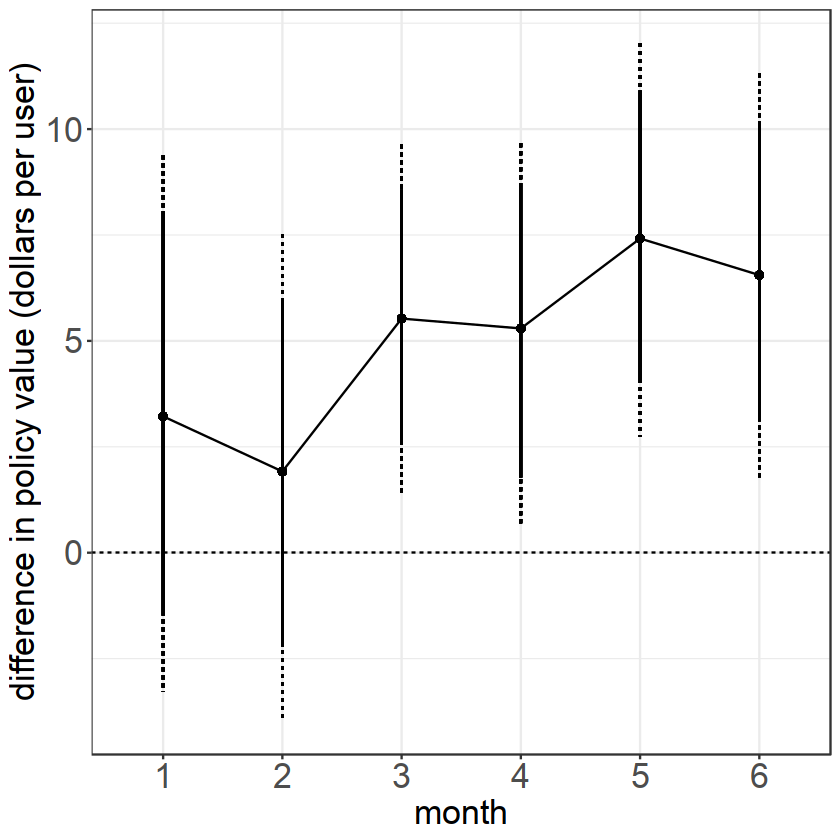

In [23]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   

### figure 3(c): comparing policy optimized on 1,2,3,4,5,6-month revenue with benchmark

In [24]:
ests_1 = read.csv('ests_1m.csv') # the difference in policy value between a policy optimized on 1-month revenue and benchmark
ests_2 = read.csv('ests_2m.csv') # the difference in policy value between a policy optimized on 2-month revenue and benchmark
ests_3 = read.csv('ests_3m.csv') # the difference in policy value between a policy optimized on 3-month revenue and benchmark
ests_4 = read.csv('ests_4m.csv') # the difference in policy value between a policy optimized on 4-month revenue and benchmark
ests_5 = read.csv('ests_5m.csv') # the difference in policy value between a policy optimized on 5-month revenue and benchmark
ests_6 = read.csv('ests_6m.csv') # the difference in policy value between a policy optimized on 6-month revenue and benchmark

In [25]:
ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

In [26]:
ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [27]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

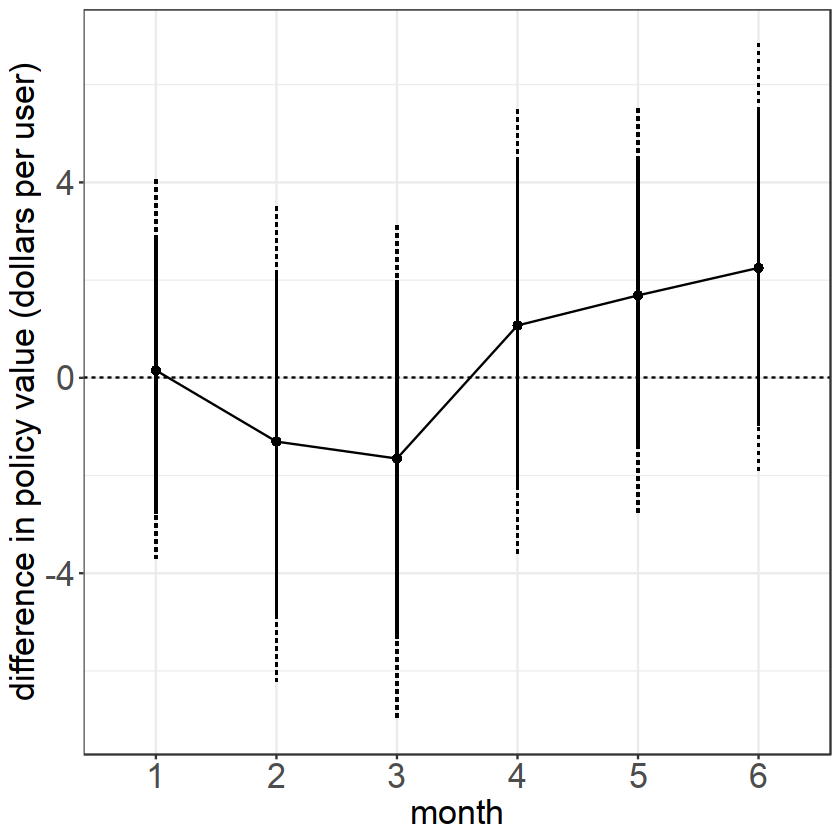

In [28]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   

### figure 3(d): comparing policy optimized on 18-month surrogate index with policy optimized on 18-month revenue

In [29]:
ests_1 = read.csv('ests_18m_1_true.csv') # the difference in policy value between policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 1 month and policy optimized on 18-month revenue
ests_2 = read.csv('ests_18m_2_true.csv') # the difference in policy value between policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 2 months and policy optimized on 18-month revenue
ests_3 = read.csv('ests_18m_3_true.csv') # the difference in policy value between policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 3 months and policy optimized on 18-month revenue
ests_4 = read.csv('ests_18m_4_true.csv') # the difference in policy value between policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 4 months and policy optimized on 18-month revenue
ests_5 = read.csv('ests_18m_5_true.csv') # the difference in policy value between policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 5 months and policy optimized on 18-month revenue
ests_6 = read.csv('ests_18m_6_true.csv') # the difference in policy value between policy optimized on surrogate index on 18-month revenue constructed with surrogates in the first 6 months and policy optimized on 18-month revenue

In [30]:
ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

In [31]:
ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [32]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

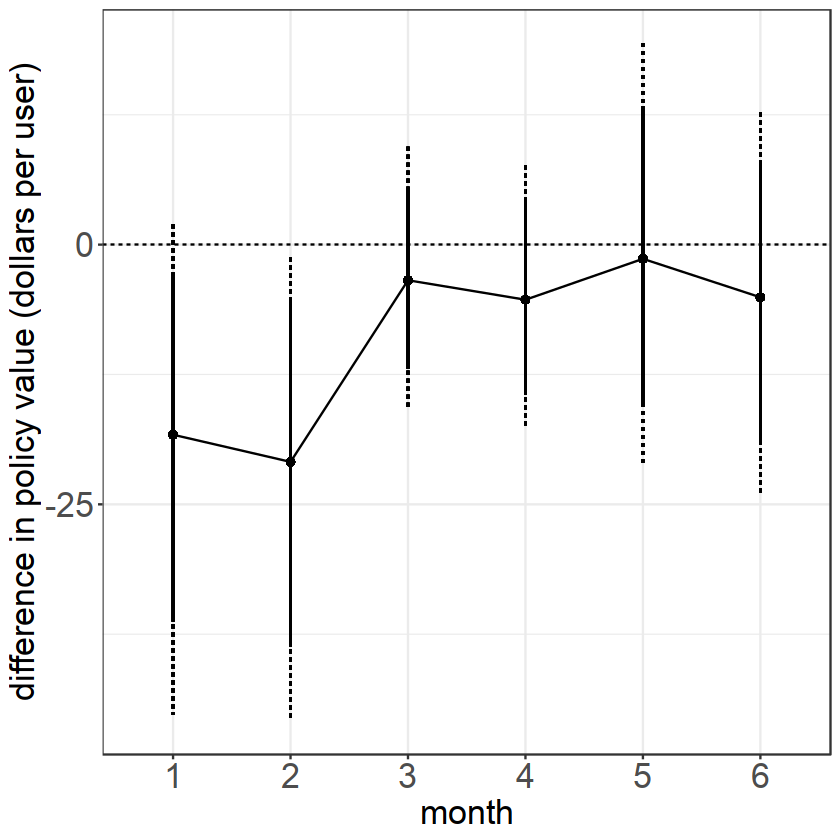

In [33]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   